# Exploring Diction and Topics in Latin Love Elegy

Patrick J. Burns
Institute for the Study of the Ancient World

Follow along at: https://github.com/diyclassics/ll-experiments

Necessary Python packages
- pip install jupyter
- pip install numpy pandas matplotlib sklearn
- pip install cltk

An iPython notebook to demonstrate the use of the Classical Language Toolkit for developing a natural language processing workflow for Latin texts and using this workflow for the basis of exploratory data analysis of diction and topics in these texts. Based on Allen Riddell's [»Text Analysis with Topic Models for the Humanities and Social Sciences«](https://de.dariah.eu/tatom/index.html).

Presented at ISAW Intro to Digital Humanities course, 12/4/17  
Presented at Yale University Classics Department, 5/18/17  
  
Last updated 11/29/17

## Set up corpora

In [5]:
# # Set up corpora

# # You will need the models/datasets that the new lemmatizer uses
# # Note that this will generate an error if this and older 
# # version of this corpus is already installed. If that happens,
# # backup the old version, move or delete it, and reimport the corpus.

# from cltk.corpus.utils.importer import CorpusImporter

# corpus_importer = CorpusImporter('latin')
# corpus_importer.list_corpora

# corpus_importer.import_corpus('latin_models_cltk')

# # We will be using the Latin Library corpus for today's workshop,
# # so we will also need to import that as well.

# corpus_importer.import_corpus('latin_text_latin_library')

## Imports

In [2]:
# In general, you want to keep imports at the front of a project, but for
# the purposes of today's workshop, it seemed better to introduce them on
# an as-needed basis. Still, here is an example of what I would usually do
# at the beginning of a notebook.

from pprint import pprint 

# pprint allows for cleaner presentation of Python objects, esp. long strings,
# lists (and nested lists), dictionaries, etc.

## Get corpus

In [6]:
# Get the Latin Library corpus

from cltk.corpus.latin import latinlibrary

# The CLTK Latin Library corpus is a web-scraped collection of plaintext files
# from thelatinlibrary.com.

# We can access the individual files as follows...

files = latinlibrary.fileids()
print(files[:50]) # The first 50 files in the corpus

# Note the [:50] slice to limit our list to the first 50 items.

len(files)

ImportError: cannot import name 'latinlibrary' from 'cltk.corpus.latin' (/Users/diyclassics/.virtualenvs/ll-experiments-GJjx61s4/lib/python3.7/site-packages/cltk/corpus/latin/__init__.py)

## Get corpus files

In [71]:
# We can iterate over the list of files to retrieve specific files. Today
# we want to work with book 1 of Propertius and book 1 of Tibullus. We
# can isolate these files by using:
# 1. list comprehension
# 2. testing for membership with 'in'

# NB: Python designates lists with square brackets, i.e. [...]; list comprehensions
# build lists in place with the following syntax...

[file for file in files if 'prop' in file]

['alcuin/propos.txt',
 'prop2.txt',
 'prop3.txt',
 'prop4.txt',
 'propertius1.txt',
 'tertullian/tertullian.propheta.txt']

In [72]:
# Here are all the files in the Latin Library with 'prop' in the filename. We
# are looking for 'propertius1.txt' and can assign it to a variable as follows...

propertius_file = 'propertius1.txt'

In [73]:
# Repeat for Tibullus

print([file for file in files if 'tib' in file])
print('\n')
pprint([file for file in files if 'tib' in file])

tibullus_file = 'tibullus1.txt'

['erasmus/antibarb.txt', 'suetonius/suet.tib.txt', 'suetonius/suet.tibullus.txt', 'tibullus1.txt', 'tibullus2.txt', 'tibullus3.txt']


['erasmus/antibarb.txt',
 'suetonius/suet.tib.txt',
 'suetonius/suet.tibullus.txt',
 'tibullus1.txt',
 'tibullus2.txt',
 'tibullus3.txt']


## Get texts

In [74]:
# Use raw function for plaintextcorpus reader to get the contents of
# the file as a string...

propertius_raw = latinlibrary.raw(propertius_file)

In [75]:
# Here is a preview of the contents...

print(propertius_raw[:500])

SEXTI PROPERTI ELEGIARVM LIBER PRIMVS

1 2 3 4 5 6 7 8a 8b 9 10 11 12 13 14 15 16 17 18 19 20 21 22

I

Cynthia prima suis miserum me cepit ocellis,
    contactum nullis ante cupidinibus.
tum mihi constantis deiecit lumina fastus
    et caput impositis pressit Amor pedibus,
donec me docuit castas odisse puellas                 5
    improbus, et nullo vivere consilio.
ei mihi, iam toto furor hic non deficit anno,
    cum tamen adversos cogor habere deos.
Milanion nullos fugiendo, Tulle, labores



In [76]:
# And a bit of the end...

print(propertius_raw[-500:]) # Note the negative slice

XXII

Qualis et unde genus, qui sint mihi, Tulle, Penates,
    quaeris pro nostra semper amicitia.
si Perusina tibi patriae sunt nota sepulcra,
    Italiae duris funera temporibus,
cum Romana suos egit discordia cives—                 5
    sic mihi praecipue, pulvis Etrusca, dolor,
tu proiecta mei perpessa's membra propinqui,
    tu nullo miseri contegis ossa solo—
proxima suppositos contingens Umbria campos
    me genuit terris fertilis uberibus.

Propertius	The Latin Library	The Classics Page


In [77]:
# Get the Tibullus texts

tibullus_raw = latinlibrary.raw(tibullus_file)

## Preprocessing

In [78]:
# Imports for preprocessing

import re # Regex module, useful for pattern matching
import html # Useful for handling entities

# Import/load a CLTK tool for normalizing i/j and u/v in Latin texts
from cltk.stem.latin.j_v import JVReplacer
replacer = JVReplacer()

In [79]:
# Preprocess texts

# I've written the following preprocessing function for today's workshop. It's
# pretty specific in a few cases—more so than I would normally would use, e.g. '8a'
# and '8b'.

# Still the goal of preprocessing is to make all of the texts we are working with
# for this experiment as uniform as possible, so that functions/processes further along
# encounter consistent data. GIGO, as they say. E.g., for today we want
# 'verbum' and 'uerbum' to be treated as the same word. For a different experiment, 
# you might not and need to make different editorial choices.

def preprocess(text):

    # Remove Latin Library-specific paratexts with regex
    
    remove_list = [r'\bThe Latin Library\b',
                   r'\bThe Classics Page\b',
                   r'\bPropertius\b',
                   r'\bSEXTI PROPERTI ELEGIARVM LIBER PRIMVS\b',
                   r'8a', r'8b', r'VIIIA', r'VIIIB',
                   r'\bTibullus Book I\b',
                   r'\bTibullus',
                   r'\bA. TIBVLLI ELEGIAE LIBER PRIMVS\b',
                   r'I II III IV V VI VII VIII IX X',
                   r'25a', r'25b'
                  ]
    
    for pattern in remove_list:
        text = re.sub(pattern, '', text)

    # Remove html entities and related html artifacts
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
    text = re.sub(r' \xa0 ', '    ', text)
    
    # Remove roman numeral headings; must be before lower & replacer
    text = re.sub(r'\b(M{1,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|M{0,4}(CM|C?D|D?C{1,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,4})|M{0,4}(CM|CD|D?C{0,3})(XC|X?L|L?X{1,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|I?V|V?I{1,3}))\b',' ',text)
    
    # Lowercase text
    text = text.lower()

    # Normalize text
    text = replacer.replace(text) #Normalize u/v & i/j
    
    # Remove punctuation with translate
    punctuation ="\"#$%&\'()+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    # Remove numbers
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    # Handle spacing
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\t',' ', text) # Remove tabs
    text = re.sub('^\s+','', text)
    text = re.sub(' \n', '\n', text)
    text = re.sub('\n\n', '~', text)
    text = re.sub('~+', '\n\n', text)
    
    return text.strip()

In [80]:
# Preprocess texts

propertius_edit = preprocess(propertius_raw)
tibullus_edit = preprocess(tibullus_raw)

In [81]:
# Preview text

print(propertius_edit[:500])

cynthia prima suis miserum me cepit ocellis
 contactum nullis ante cupidinibus
tum mihi constantis deiecit lumina fastus
 et caput impositis pressit amor pedibus
donec me docuit castas odisse puellas
 improbus et nullo uiuere consilio
ei mihi iam toto furor hic non deficit anno
 cum tamen aduersos cogor habere deos
milanion nullos fugiendo tulle labores
 saeuitiam durae contudit iasidos
nam modo partheniis amens errabat in antris
 rursus in hirsutas ibat et ille feras
ille etiam hylaei percussus


In [82]:
# Compare to raw plaintext from LL...

print(propertius_raw[:500])

SEXTI PROPERTI ELEGIARVM LIBER PRIMVS

1 2 3 4 5 6 7 8a 8b 9 10 11 12 13 14 15 16 17 18 19 20 21 22

I

Cynthia prima suis miserum me cepit ocellis,
    contactum nullis ante cupidinibus.
tum mihi constantis deiecit lumina fastus
    et caput impositis pressit Amor pedibus,
donec me docuit castas odisse puellas                 5
    improbus, et nullo vivere consilio.
ei mihi, iam toto furor hic non deficit anno,
    cum tamen adversos cogor habere deos.
Milanion nullos fugiendo, Tulle, labores



## Split text into list of poems

In [83]:
# We have set up the preprocessing to leave two blank lines between
# each poem in the original string. We can use 'split' to break the
# text up into a list of strings, each string containing one poem.

propertius = propertius = propertius_edit.split('\n\n')
tibullus = tibullus_edit.split('\n\n')

In [84]:
# Check length of list

print(len(propertius))
print(len(tibullus))

23
10


In [85]:
# Preview first line of each poem in Propertius list...

for poem in propertius:
    print(poem[:poem.find('\n')])

cynthia prima suis miserum me cepit ocellis
quid iuuat ornato procedere uita capillo
qualis thesea iacuit cedente carina
quid mihi tam multas laudando basse puellas
quid tibi uis insane meae sentire furores
non ego nunc hadriae uereor mare noscere tecum
dum tibi cadmeae dicuntur pontice thebae
tune igitur demens nec te mea cura moratur
hic erit hic iurata manet rumpantur iniqui
dicebam tibi uenturos irrisor amores
o iucunda quies primo cum testis amori
ecquid te mediis cessantem cynthia baiis
quid mihi desidiae non cessas fingere crimen
tu quod saepe soles nostro laetabere casu
tu licet abiectus tiberina molliter unda
saepe ego multa tuae leuitatis dura timebam
quae fueram magnis olim patefacta triumphis
et merito quoniam potui fugisse puellam
haec certe deserta loca et taciturna querenti
non ego nunc tristis uereor mea cynthia manes
hoc pro continuo te galle monemus amore
tu qui consortem properas euadere casum
qualis et unde genus qui sint mihi tulle penates


## Set up titles

In [86]:
tibullus_titles = ['Tib. 1.1', 'Tib. 1.2', 'Tib. 1.3', 'Tib. 1.4', 'Tib. 1.5', 
                   'Tib. 1.6', 'Tib. 1.7', 'Tib. 1.8', 'Tib. 1.9', 'Tib. 1.10']

propertius_titles = ['Prop. 1.1', 'Prop. 1.2', 'Prop. 1.3', 'Prop. 1.4', 'Prop. 1.5', 
                     'Prop. 1.6', 'Prop. 1.7', 'Prop. 1.8a', 'Prop. 1.8b', 'Prop. 1.9', 
                     'Prop. 1.10', 'Prop. 1.11', 'Prop. 1.12', 'Prop. 1.13', 'Prop. 1.14', 
                     'Prop. 1.15', 'Prop. 1.16', 'Prop. 1.17', 'Prop. 1.18', 'Prop. 1.19', 
                     'Prop. 1.20', 'Prop. 1.21', 'Prop. 1.22']


In [87]:
# Preview titles with first lines…

for i, poem in enumerate(propertius[:5]):
    print(propertius_titles[i],
          '\n',
          poem[:poem.find('\n')],
          '\n')

Prop. 1.1 
 cynthia prima suis miserum me cepit ocellis 

Prop. 1.2 
 quid iuuat ornato procedere uita capillo 

Prop. 1.3 
 qualis thesea iacuit cedente carina 

Prop. 1.4 
 quid mihi tam multas laudando basse puellas 

Prop. 1.5 
 quid tibi uis insane meae sentire furores 



## Tokenize words

In [88]:
# Here is what we have...

print(propertius[0])

cynthia prima suis miserum me cepit ocellis
 contactum nullis ante cupidinibus
tum mihi constantis deiecit lumina fastus
 et caput impositis pressit amor pedibus
donec me docuit castas odisse puellas
 improbus et nullo uiuere consilio
ei mihi iam toto furor hic non deficit anno
 cum tamen aduersos cogor habere deos
milanion nullos fugiendo tulle labores
 saeuitiam durae contudit iasidos
nam modo partheniis amens errabat in antris
 rursus in hirsutas ibat et ille feras
ille etiam hylaei percussus uulnere rami
 saucius arcadiis rupibus ingemuit
ergo uelocem potuit domuisse puellam
 tantum in amore fides et benefacta ualent
in me tardus amor non ullas cogitat artes
 nec meminit notas ut prius ire uias
at uos deductae quibus est pellacia lunae
 et labor in magicis sacra piare focis
en agedum dominae mentem conuertite nostrae
 et facite illa meo palleat ore magis
tunc ego crediderim manes et sidera uobis
 posse cytinaeis ducere carminibus
aut uos qui sero lapsum reuocatis amici
 quaerite no

In [89]:
# What we want is a list of all of the words in the poem. This is word tokenization and
# it will largely be done by splitting the text on whitespace, thought the CLTK
# has language-specific tokenization to handle language-specific problems, e.g.
# What would you want to extract from 'arma virumque cano'? ['virum'] or ['virum', '-que']?

In [90]:
# Set up CLTK Latin word tokenizer

from cltk.tokenize.word import WordTokenizer
word_tokenizer = WordTokenizer('latin')

In [91]:
# Here is what the same poem looks like as a list of tokens
print(word_tokenizer.tokenize(propertius[0]))
print(len(word_tokenizer.tokenize(propertius[0])))

['cynthia', 'prima', 'suis', 'miserum', 'me', 'cepit', 'ocellis', 'contactum', 'nullis', 'ante', 'cupidinibus', 'tum', 'mihi', 'constantis', 'deiecit', 'lumina', 'fastus', 'et', 'caput', 'impositis', 'pressit', 'amor', 'pedibus', 'donec', 'me', 'docuit', 'castas', 'odisse', 'puellas', 'improbus', 'et', 'nullo', 'uiuere', 'consilio', 'ei', 'mihi', 'iam', 'toto', 'furor', 'hic', 'non', 'deficit', 'anno', 'cum', 'tamen', 'aduersos', 'cogor', 'habere', 'deos', 'milanio', '-ne', 'nullos', 'fugiendo', 'tulle', 'labores', 'saeuitiam', 'durae', 'contudit', 'iasidos', 'nam', 'modo', 'partheniis', 'amens', 'errabat', 'in', 'antris', 'rursus', 'in', 'hirsutas', 'ibat', 'et', 'ille', 'feras', 'ille', 'etiam', 'hylaei', 'percussus', 'uulnere', 'rami', 'saucius', 'arcadiis', 'rupibus', 'ingemuit', 'ergo', 'uelocem', 'potuit', 'domuisse', 'puellam', 'tantum', 'in', 'amore', 'fides', 'et', 'benefacta', 'ualent', 'in', 'me', 'tardus', 'amor', 'non', 'ullas', 'cogitat', 'artes', 'nec', 'meminit', 'notas

In [92]:
# Tokenize list of poems

# Again we can use list comprehensions to create orderly lists of lists of tokens.

propertius_tokens = [word_tokenizer.tokenize(poem) for poem in propertius]
tibullus_tokens = [word_tokenizer.tokenize(poem) for poem in tibullus]

## Lemmatize tokens

In [93]:
# What we now want is a list of all of the lemmata, i.e. the dictionary headword, in 
# the poem. CLTK has Latin-specific lemmatizers that make automatic and 'informed' 
# decisions about which headword to pick. The accuracy of the lemmatizer we will
# use today—the backoff lemmatizer—is constantly improving and is roughly 90% at present,
# which should be sufficient for today's experiments.

In [94]:
# We need to import a data model to train the lemmatizer.

import os
from cltk.utils.file_operations import open_pickle

# Set up training sentences

rel_path = os.path.join('~/cltk_data/latin/model/latin_models_cltk/lemmata/backoff')
path = os.path.expanduser(rel_path)

# Check for presence of latin_pos_lemmatized_sents
file = 'latin_pos_lemmatized_sents.pickle'      

latin_pos_lemmatized_sents_path = os.path.join(path, file)
if os.path.isfile(latin_pos_lemmatized_sents_path):
    latin_pos_lemmatized_sents = open_pickle(latin_pos_lemmatized_sents_path)
else:
    latin_pos_lemmatized_sents = []
    print('The file %s is not available in cltk_data' % file)  

In [95]:
# Set up CLTK Latin backoff lemmatizer

from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer
lemmatizer = BackoffLatinLemmatizer(latin_pos_lemmatized_sents)

In [96]:
# This lemmatizer, while more accurate than others, can be **very** slow. So, for
# the purposes of today's workshop, we will use a 'trick' to speed it up, i.e.
# rejoin the list of tokens and process two strings rather than a list of all the tokens.

## Make one string of all files, delimited by |||
## (NB: Attempt to reduce the number of regex compiles.)

def create_lemmatized_texts(texts):
    textin = " ||| ".join(texts)
    tokens = textin.split()
    lemmas = lemmatizer.lemmatize(tokens)
    textout = " ".join(lemma[1] for lemma in lemmas)
    punctuation ="\"#$%&\'()+,-/:;<=>@[\]^_`{}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    textout = textout.translate(translator)
    translator = str.maketrans({key: " " for key in '0123456789'})
    textout = textout.translate(translator)
    textout = re.sub(r' punc ', ' ', textout)
    lemmatized_texts = textout.split('|||')
    return lemmatized_texts


In [97]:
print(create_lemmatized_texts(propertius[:1]))

['cynthia primus suus miser ego capio ocellus contingo nullus ante cupido tum ego consto deicio lumen fastus et caput impono premo amor pes donec ego doceo castus odi puella improbus et nullus uiuo consilium is ego iam totus furor hic non deficio annus cum  tamen aduerto cogo habeo deus milanion nullus fugio tullus labor saevitia durus contundo iasidos nam modo parthenius amens erro in antrum rursus in hirsutus eo et ille ferus ille etiam hylaeus percutio uulnus ramus saucius arcadius rupes ingemo ergo uelox possum domo puella tantus in amor fides et benefacio ualeo in ego tardus amor non ullus cogito ars neque memini nosco ut prior eo uia at tu deduco qui sum pellacia luna et labor in magicus sacer piaris focus en agedum domina mens conuerto noster et facio ille meus palleo os magis tunc ego credo manes et sidus tu possum cytinaeis duco carmen aut tu qui serus labor reuoco amicus quaero non sanus pector auxilium fortis et ferrum saeuus patior et ignis sum modo libertas qui uolo ira lo

In [98]:
# As noted above, rejoin list of tokens...
propertius_tokenized_texts = [' '.join(tokens) for tokens in propertius_tokens]
tibullus_tokenized_texts = [' '.join(tokens) for tokens in tibullus_tokens]

# ... and lemmatize.
propertius_lemmatized_texts = create_lemmatized_texts(propertius_tokenized_texts)
tibullus_lemmatized_texts = create_lemmatized_texts(tibullus_tokenized_texts)

In [99]:
# Now let's split our lemmatized texts into a list of lemmas, first by getting
# a list of lemmas per poem...

propertius_lemmas = [text.split() for text in propertius_lemmatized_texts]
tibullus_lemmas = [text.split() for text in tibullus_lemmatized_texts]

# ... then by flattening these lists into a single author list.

propertius_lemmas = [item for sublist in propertius_lemmas for item in sublist]
tibullus_lemmas = [item for sublist in tibullus_lemmas for item in sublist]

## Counting words

In [100]:
# Now that we have a list of lemmas from our authors, we can use the Counter
# object in Python to get some frequency information about "words"

from collections import Counter

# Build counter of top token counts
propertius_lemmas_counter = Counter(propertius_lemmas)
propertius_lemmas_mc = propertius_lemmas_counter.most_common(100)

running = 0

print('Top 25 lemmas in Propertius 1:\n')
print("{number:>5}  {lemma:<12}{count:<12}{percent:<12}{running:<12}".format(number="", lemma="lemma", count="COUNT", percent="Type-Tok %", running = "RUNNING %"))
for i, pair in enumerate(propertius_lemmas_mc[:25]):
    running += pair[1]
    print("{number:>5}. {lemma:<12}{count:<12}{percent:<12}{running:<12}".format(number=i+1, lemma=pair[0], count=pair[1], percent=str(round(pair[1] / len(propertius_lemmas)*100, 2))+"%", running = str(round(running / len(propertius_lemmas)*100, 2))+"%"))

Top 25 lemmas in Propertius 1:

       lemma       COUNT       Type-Tok %  RUNNING %   
    1. et          135         3.05%       3.05%       
    2. sum         124         2.81%       5.86%       
    3. tu          113         2.56%       8.42%       
    4. ego         106         2.4%        10.81%      
    5. non         84          1.9%        12.71%      
    6. qui         64          1.45%       14.16%      
    7. amor        61          1.38%       15.54%      
    8. meus        57          1.29%       16.83%      
    9. ille        51          1.15%       17.99%      
   10. neque       49          1.11%       19.1%       
   11. hic         48          1.09%       20.18%      
   12. in          47          1.06%       21.24%      
   13. possum      42          0.95%       22.19%      
   14. noster      32          0.72%       22.92%      
   15. tuus        31          0.7%        23.62%      
   16. cynthia     30          0.68%       24.3%       
   17. puella   

In [101]:
# Build counter of top token counts
tibullus_lemmas_counter = Counter(tibullus_lemmas)
tibullus_lemmas_mc = tibullus_lemmas_counter.most_common(100)

running = 0

print('Top 25 lemmas in Tibullus 1:\n')
print("{number:>5}  {lemma:<12}{count:<12}{percent:<12}{running:<12}".format(number="", lemma="lemma", count="COUNT", percent="Type-Tok %", running = "RUNNING %"))
for i, pair in enumerate(tibullus_lemmas_mc[:25]):
    running += pair[1]
    print("{number:>5}. {lemma:<12}{count:<12}{percent:<12}{running:<12}".format(number=i+1, lemma=pair[0], count=pair[1], percent=str(round(pair[1] / len(tibullus_lemmas)*100, 2))+"%", running = str(round(running / len(tibullus_lemmas)*100, 2))+"%"))

Top 25 lemmas in Tibullus 1:

       lemma       COUNT       Type-Tok %  RUNNING %   
    1. et          148         2.75%       2.75%       
    2. sum         120         2.23%       4.99%       
    3. ego         108         2.01%       6.99%       
    4. que         106         1.97%       8.97%       
    5. tu          101         1.88%       10.84%      
    6. non         68          1.26%       12.11%      
    7. hic         61          1.13%       13.24%      
    8. qui         56          1.04%       14.29%      
    9. ille        56          1.04%       15.33%      
   10. neque       48          0.89%       16.22%      
   11. in          43          0.8%        17.02%      
   12. at          38          0.71%       17.73%      
   13. cum         38          0.71%       18.43%      
   14. ipse        36          0.67%       19.1%       
   15. sed         34          0.63%       19.74%      
   16. amor        33          0.61%       20.35%      
   17. meus       

## Words as features

In [102]:
# Here we will quickly go through the kinds of exploratory data analysis available
# to us once we have preprocessed or tokenized or lemmatized texts, spec.

# - Visualizing texts by "distance" based on vocabulary
# - Visualizing automatically extracted topics based on word co-occurence

In [103]:
# Import modules

import numpy as np
import pandas as pd
import sklearn.feature_extraction.text as text

# Create an instance of a count vectorizer
vectorizer = text.CountVectorizer(input='content')

In [104]:
# Create a document-term matrix, i.e. reduce our texts to an array where
# - the horizontal axis is a list of words
# - the vertical axis is a list of documents
# - the intersection of the two axes is the count of the word in the document

# Take two sentences:
# - Omnia vincit amor.
# - Omnia vincit labor.

# Reduce the setences to document-term matrix
dtm = vectorizer.fit_transform(['Omnia vincit amor.', 'Omnia vincit labor.'])
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())

# Print the complete list of words from both sentences
print(vocab)
print('\n')

# Print a table with the dtm
pd.DataFrame(dtm, columns=vocab)


['amor' 'labor' 'omnia' 'vincit']




,amor,labor,omnia,vincit
0,1,0,1,1
1,0,1,1,1


In [105]:
# Obviously for a complete work, the matrix is much larger (and more
# sparse, i.e. lots of zeroes).

dtm = vectorizer.fit_transform(propertius_lemmatized_texts)
dtm = dtm.toarray()
vocab = np.array(vectorizer.get_feature_names())

# Print the complete list of words from both sentences
print(vocab)
print('\n')

# Print a table with the dtm
pd.DataFrame(dtm, columns=vocab)


['ab' 'abeo' 'abicio' ..., 'zephyro' 'zephyrus' 'zetes']




,ab,abeo,abicio,abripio,abstraho,absum,accedo,accendo,accipio,accumbo,...,uulnus,vago,vagus,venio,verro,vincio,violo,zephyro,zephyrus,zetes
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Plotting vector space

In [106]:
# Imports

import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

In [107]:
# Compute Euclidean distance across the document-term matrix
dist = 1 - cosine_similarity(dtm)

# Reduce dimensionality
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)

# Get coordinates
pos = mds.fit_transform(dist)
xs, ys = pos[:,0], pos[:,1]

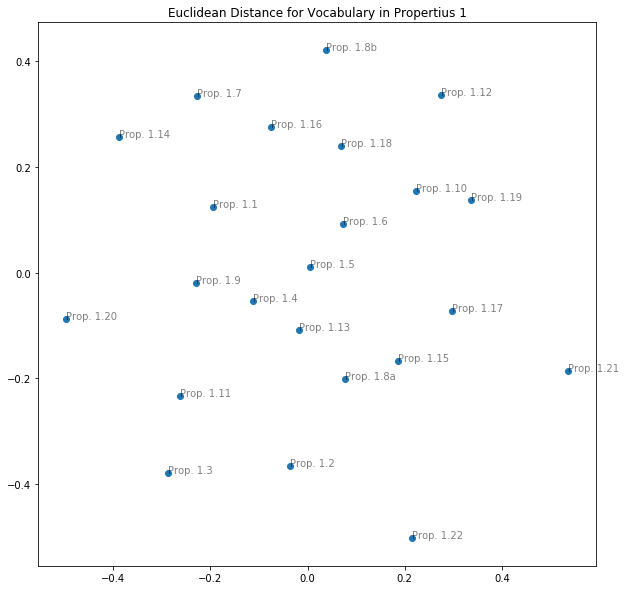

In [108]:
# Create scatterplot

plt.figure(figsize=(10,10))
plt.title('Euclidean Distance for Vocabulary in Propertius 1')
plt.scatter(xs, ys, cmap='spring')
for x, y, name in zip(xs, ys, propertius_titles):
    plt.text(x,y,name,alpha=0.5,fontsize=10)
plt.show()

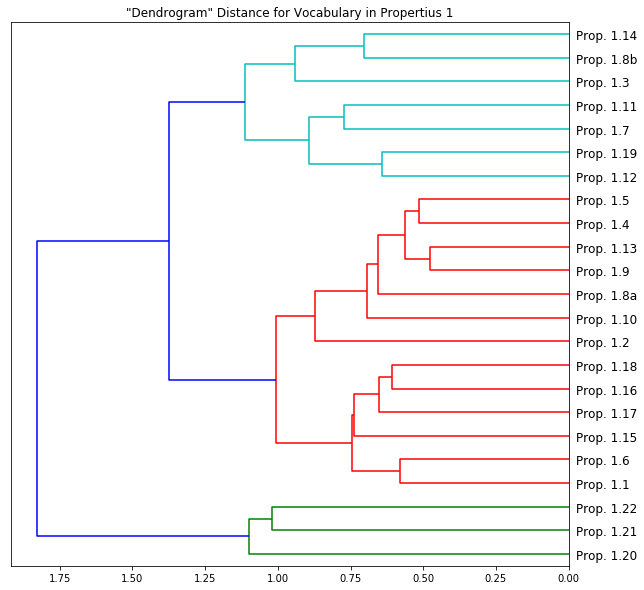

In [109]:
# We can view these distance measures as a branching tree as well

from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(dist)

plt.figure(figsize=(10,10))
plt.title('"Dendrogram" Distance for Vocabulary in Propertius 1')
dendrogram(linkage_matrix, orientation="left", labels=propertius_titles, leaf_font_size=12);
plt.show()

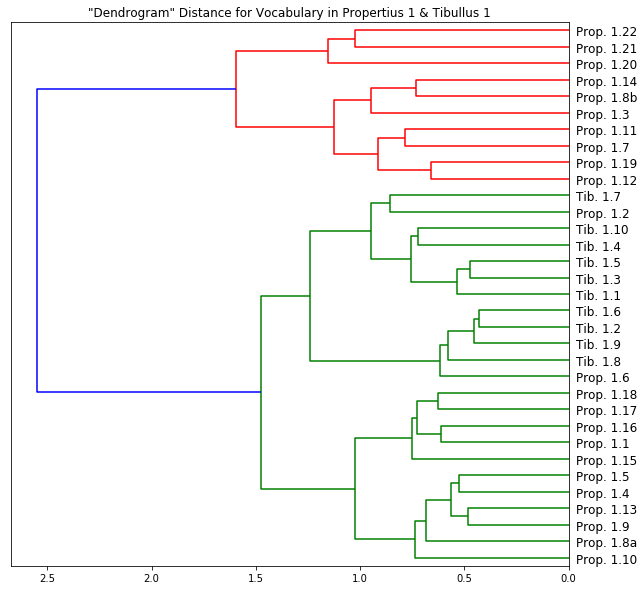

In [110]:
# We can combine our two elegist to visualize them together

texts = propertius_lemmatized_texts + tibullus_lemmatized_texts
titles = propertius_titles + tibullus_titles

dtm = vectorizer.fit_transform(texts)
dtm = dtm.toarray()

dist = 1 - cosine_similarity(dtm)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
pos = mds.fit_transform(dist)
linkage_matrix = ward(dist)

plt.figure(figsize=(10,10))
plt.title('"Dendrogram" Distance for Vocabulary in Propertius 1 & Tibullus 1')
dendrogram(linkage_matrix, orientation="left", labels=titles, leaf_font_size=12);
plt.show()

"The fact that four words (out of eighty-four) in a Propertian passage, and words that are hardly unusual or remarkable, bear some similarity to four words (out ofthirty-four) in some lines of Tibullus provides extremely weak grounds for claiming Propertian influence." (Murgatroyd, P. 1982. "Reply to Review," *Acta Classica* 25: 145-147.)

## Visualizing topics

In [111]:
# Get Latin stopword list

from cltk.stop.latin.stops import STOPS_LIST as latin_stops

In [112]:
latin_stops = latin_stops[:91]
latin_stops.extend(['que'])
print(latin_stops)

['ab', 'ac', 'ad', 'adhic', 'aliqui', 'aliquis', 'an', 'ante', 'apud', 'at', 'atque', 'aut', 'autem', 'cum', 'cur', 'de', 'deinde', 'dum', 'ego', 'enim', 'ergo', 'es', 'est', 'et', 'etiam', 'etsi', 'ex', 'fio', 'haud', 'hic', 'iam', 'idem', 'igitur', 'ille', 'in', 'infra', 'inter', 'interim', 'ipse', 'is', 'ita', 'magis', 'modo', 'mox', 'nam', 'ne', 'nec', 'necque', 'neque', 'nisi', 'non', 'nos', 'o', 'ob', 'per', 'possum', 'post', 'pro', 'quae', 'quam', 'quare', 'qui', 'quia', 'quicumque', 'quidem', 'quilibet', 'quis', 'quisnam', 'quisquam', 'quisque', 'quisquis', 'quo', 'quoniam', 'sed', 'si', 'sic', 'sive', 'sub', 'sui', 'sum', 'super', 'suus', 'tam', 'tamen', 'trans', 'tu', 'tum', 'ubi', 'uel', 'uero', 'unus', 'que']


In [113]:
import sklearn.feature_extraction.text as text
vectorizer = text.CountVectorizer(input='content', stop_words=latin_stops, min_df=2) # Note cutoff of two words
dtm = vectorizer.fit_transform(texts).toarray()
vocab = np.array(vectorizer.get_feature_names())

dtm.shape

(33, 1031)

In [114]:
from sklearn import decomposition
num_topics = 10
num_top_words = 25
clf = decomposition.NMF(n_components=num_topics, random_state=1) # Using non-negative matrix factorization

# For more on NMF, see https://de.dariah.eu/tatom/topic_model_python.html

doctopic = clf.fit_transform(dtm)

In [115]:
# Create list of words per "topic" (i.e. classifier component)

topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])


In [116]:
# Scale the document-component matrix such that the component values
# associated with each document sum to one.

doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

In [117]:
names = np.asarray(titles)
doctopic_orig = doctopic.copy()

# Create empty matrix
num_groups = len(set(names))
doctopic_grouped = np.zeros((num_groups, num_topics))


In [118]:
# Populate matrix 

for i, name in enumerate(sorted(set(names))):
    doctopic_grouped[i, :] = np.mean(doctopic[names == name, :], axis=0)

doctopic = doctopic_grouped

In [119]:
# Make dataframe for clearer display

df = pd.DataFrame(data=doctopic, index=titles).round(2)
df

,0,1,2,3,4,5,6,7,8,9
Prop. 1.1,0.59,0.18,0.00,0.12,0.00,0.00,0.00,0.12,0.00,0.00
Prop. 1.2,0.65,0.00,0.00,0.15,0.01,0.00,0.00,0.00,0.18,0.00
Prop. 1.3,0.66,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.20
Prop. 1.4,0.76,0.00,0.06,0.00,0.00,0.03,0.00,0.11,0.00,0.04
Prop. 1.5,0.68,0.18,0.00,0.09,0.05,0.00,0.00,0.00,0.00,0.00
Prop. 1.6,0.54,0.17,0.00,0.20,0.00,0.00,0.09,0.00,0.00,0.00
Prop. 1.7,0.35,0.05,0.00,0.00,0.16,0.00,0.37,0.07,0.00,0.00
Prop. 1.8a,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.69,0.00
Prop. 1.8b,0.56,0.00,0.27,0.00,0.00,0.05,0.00,0.00,0.12,0.00
Prop. 1.9,0.61,0.00,0.09,0.00,0.12,0.00,0.00,0.00,0.18,0.00


In [120]:
# Show top three topics per document

print("Top NMF topics in...")
for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ' '.join(str(t) for t in top_topics)
    print("{}: {}".format(titles[i], top_topics_str))

Top NMF topics in...
Prop. 1.1: 0 1 7
Prop. 1.2: 0 8 3
Prop. 1.3: 0 9 3
Prop. 1.4: 0 7 2
Prop. 1.5: 0 1 3
Prop. 1.6: 0 3 1
Prop. 1.7: 6 0 4
Prop. 1.8a: 8 0 9
Prop. 1.8b: 0 2 8
Prop. 1.9: 0 8 4
Prop. 1.10: 0 5 1
Prop. 1.11: 9 7 0
Prop. 1.12: 0 1 5
Prop. 1.13: 0 8 4
Prop. 1.14: 0 5 7
Prop. 1.15: 7 0 5
Prop. 1.16: 0 9 2
Prop. 1.17: 0 4 3
Prop. 1.18: 0 3 4
Prop. 1.19: 0 1 7
Prop. 1.20: 0 2 8
Prop. 1.21: 0 8 2
Prop. 1.22: 0 5 6
Tib. 1.1: 2 9 8
Tib. 1.2: 9 2 8
Tib. 1.3: 3 9 8
Tib. 1.4: 5 9 8
Tib. 1.5: 1 9 8
Tib. 1.6: 8 9 1
Tib. 1.7: 6 8 2
Tib. 1.8: 9 1 7
Tib. 1.9: 7 9 8
Tib. 1.10: 4 9 8


In [123]:
# Show words associated with each document

for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:25])))

Topic 0: amor meus cynthia noster tuus puella nullus durus dolor ut ullus cogo eo primus quaero carmen longus saepe ocellus semper labor solus tantus uerbum dico
Topic 1: uolo puer amor do dies aqua uenus doceo primus fero annus tener capio ars nudus deus nego heu cito longus eo tuus uinco leuis iuuenis
Topic 2: meus fero pono teneo nunc tener iners parco fleo domus lio ut sinus paruus uia seu do bonus satis lectus aurum puella contineo pomum exiguus
Topic 3: amor pono neu uenus meus seu totus deus nox dico teneo uolo puella omnis magicus iuuenis credo solus lumen cantus multus mollis uideo ianua lio
Topic 4: tuus multus meus deus puer facio aurum amor uerbum uolo miser fleo corpus pes uendo saepe fero nunc noster munus poena uro peto do nullus
Topic 5: nunc illic terra amor os mors porto sacer lio do dico tuus semper longus unda uia auis precor foris teneo deus meus manus puer uenio
Topic 6: amor tuus ut manus duco magnus procul sto meus multus credo saepe sanguis timeo dico nunc aliu

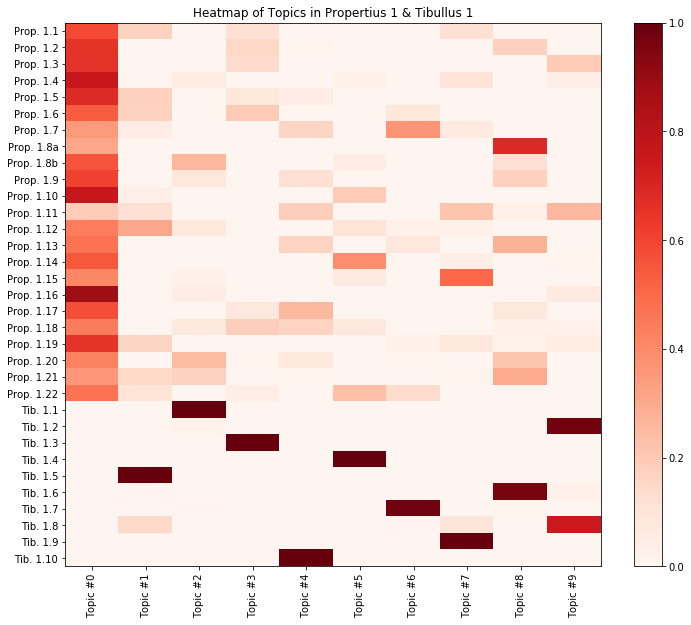

In [124]:
# Make heatmap of topics

N, K = doctopic.shape  # N documents, K topics
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

plt.figure(figsize=(12,10))
plt.title("Heatmap of Topics in Propertius 1 & Tibullus 1")
plt.pcolor(doctopic, norm=None, cmap='Reds')
plt.yticks(np.arange(doctopic.shape[0])+0.5, names);
plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.colorbar(cmap='Reds')
plt.show()

In [125]:
# Show list of words again

for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: amor meus cynthia noster tuus puella nullus durus dolor ut ullus cogo eo primus quaero
Topic 1: uolo puer amor do dies aqua uenus doceo primus fero annus tener capio ars nudus
Topic 2: meus fero pono teneo nunc tener iners parco fleo domus lio ut sinus paruus uia
Topic 3: amor pono neu uenus meus seu totus deus nox dico teneo uolo puella omnis magicus
Topic 4: tuus multus meus deus puer facio aurum amor uerbum uolo miser fleo corpus pes uendo
Topic 5: nunc illic terra amor os mors porto sacer lio do dico tuus semper longus unda
Topic 6: amor tuus ut manus duco magnus procul sto meus multus credo saepe sanguis timeo dico
Topic 7: do deus ut cantus puer uenus nox saepe caput serus osculum miser nunc muto amo
Topic 8: meus nunc pauper omnis uotum uerbum dico domina deus amo solus semper saepe do manus
Topic 9: tener gero primus facio bellum candidus uenio do satis aqua caput ut punc arma fundo


In [126]:
latin_stops.extend(['cynthia'])

In [127]:
import sklearn.feature_extraction.text as text
vectorizer = text.CountVectorizer(input='content', stop_words=latin_stops, min_df=2) # Note cutoff of two words
dtm = vectorizer.fit_transform(texts).toarray()
vocab = np.array(vectorizer.get_feature_names())

dtm.shape

(33, 1030)

In [128]:
from sklearn import decomposition
num_topics = 10
num_top_words = 25
clf = decomposition.NMF(n_components=num_topics, random_state=1) # Using non-negative matrix factorization

# For more on NMF, see https://de.dariah.eu/tatom/topic_model_python.html

doctopic = clf.fit_transform(dtm)

In [129]:
# Create list of words per "topic" (i.e. classifier component)

topic_words = []

for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [130]:
# Scale the document-component matrix such that the component values
# associated with each document sum to one.

doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

In [131]:
names = np.asarray(titles)
doctopic_orig = doctopic.copy()

# Create empty matrix
num_groups = len(set(names))
doctopic_grouped = np.zeros((num_groups, num_topics))

In [132]:
# Populate matrix 

for i, name in enumerate(sorted(set(names))):
    doctopic_grouped[i, :] = np.mean(doctopic[names == name, :], axis=0)

doctopic = doctopic_grouped

In [133]:
# Make dataframe for clearer display

df = pd.DataFrame(data=doctopic, index=titles).round(2)

In [134]:
# Show words associated with each document

for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:25])))

Topic 0: amor meus noster tuus puella nullus durus dolor ut cogo ullus eo quaero carmen saepe primus semper labor ocellus longus dico uerbum tantus manus pereo
Topic 1: uolo puer amor do dies aqua uenus doceo primus fero annus capio tener ars nego nudus heu deus cito longus eo tuus uinco terra leuis
Topic 2: meus fero teneo pono tener iners nunc parco fleo domus lio ut sinus do paruus uia seu lectus bonus satis puella contineo aurum exiguus uenio
Topic 3: amor pono neu uenus meus seu totus deus nox teneo dico omnis uolo puella noster solus magicus multus mollis credo iuuenis lumen cantus lio ianua
Topic 4: tuus multus meus deus facio puer aurum amor uerbum miser uolo fleo pes corpus uendo noster nunc saepe munus fero uro peto poena do duco
Topic 5: nunc illic terra amor os mors porto sacer lio do dico longus tuus semper uia unda foris auis precor teneo deus meus puer manus uenio
Topic 6: amor tuus ut duco manus magnus sto procul meus multus credo saepe sanguis timeo dico nunc deus nesc

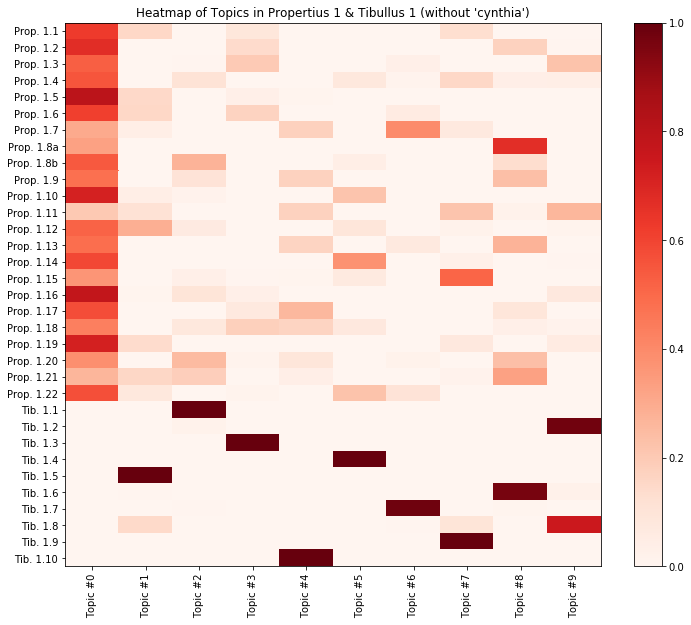

In [135]:
# Make heatmap of topics

N, K = doctopic.shape  # N documents, K topics
topic_labels = ['Topic #{}'.format(k) for k in range(K)]

plt.figure(figsize=(12,10))
plt.title("Heatmap of Topics in Propertius 1 & Tibullus 1 (without 'cynthia')")
plt.pcolor(doctopic, norm=None, cmap='Reds')
plt.yticks(np.arange(doctopic.shape[0])+0.5, names);
plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);
plt.gca().invert_yaxis()
plt.xticks(rotation=90)
plt.colorbar(cmap='Reds')
plt.show()